In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


[Learn the Basics](intro.html) ||
[Quickstart](quickstart_tutorial.html) ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
**Build Model** ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Build the Neural Network

Neural networks comprise of layers/modules that perform operations on data.
The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace provides all the building blocks you need to
build your own neural network. Every module in PyTorch subclasses the [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules (layers). This nested structure allows for
building and managing complex architectures easily.

In the following sections, we'll build a neural network to classify images in the FashionMNIST dataset.


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Get Device for Training
We want to be able to train our model on a hardware accelerator like the GPU or MPS,
if available. Let's check to see if [torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html)
or [torch.backends.mps](https://pytorch.org/docs/stable/notes/mps.html) are available, otherwise we use the CPU.



In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Define the Class
We define our neural network by subclassing ``nn.Module``, and
initialize the neural network layers in ``__init__``. Every ``nn.Module`` subclass implements
the operations on input data in the ``forward`` method.



In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of ``NeuralNetwork``, and move it to the ``device``, and print
its structure.



In [5]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model's ``forward``,
along with some [background operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
Do not call ``model.forward()`` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output.
We get the prediction probabilities by passing it through an instance of the ``nn.Softmax`` module.



In [6]:
X = torch.rand(1, 28, 28, device=device)
print(X.shape)
# model是一个函数，还是一个类实例，这是什么语法
logits = model(X)
print(logits.shape)
print(logits)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

torch.Size([1, 28, 28])
torch.Size([1, 10])
tensor([[ 0.0671,  0.0102,  0.0687,  0.0142, -0.1234, -0.0380, -0.1045, -0.0796,
          0.1199, -0.0501]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted class: tensor([8], device='cuda:0')


--------------




## Model Layers

Let's break down the layers in the FashionMNIST model. To illustrate it, we
will take a sample minibatch of 3 images of size 28x28 and see what happens to it as
we pass it through the network.



In [7]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten(将数组打平)
We initialize the [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (
the minibatch dimension (at dim=0) is maintained).



In [8]:
# https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten
# flatten是将数组打平，不包含第一个维度
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear(神经网络中的一层)
The [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its stored weights and biases.




In [9]:
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
# 根据它的文档说明，它是不管第一个维度的，所以[3, 784]变成[3,20]
# 内部怎么算的，就不懂了
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### 我的Linear分析

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

Linear表达神经网络的一层

按照这个图，做一个Linear
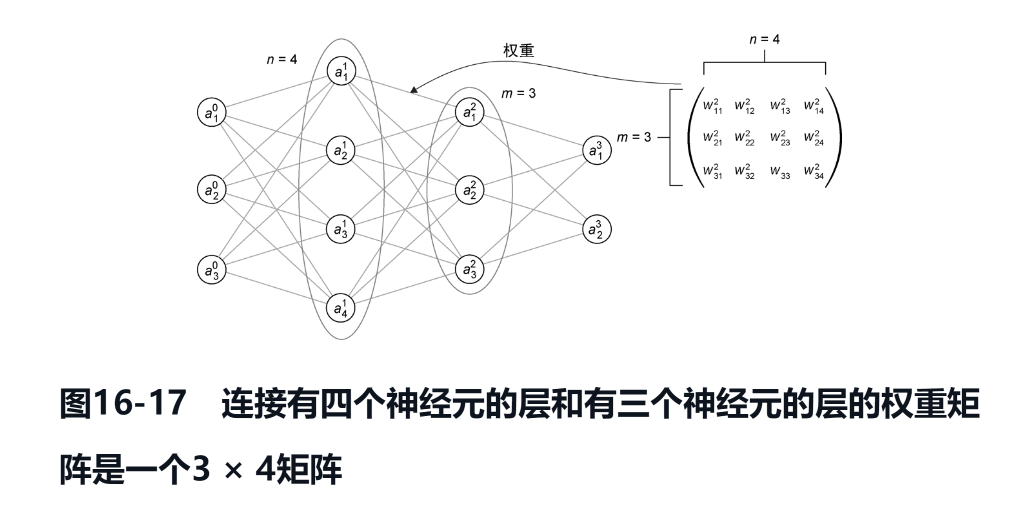

<b>下图显示了Linear内部的计算公式</b>

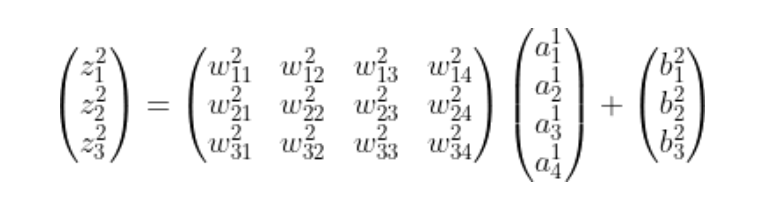

In [10]:
# 上图中的第三层（m=3)，从4个节点转为3个节点
m = nn.Linear(4, 3)
# 生成了两条数据，每个数据有4个字段
input = torch.randn(2, 4)
# 输出的数据还是两条，但是有3个字段
output = m(input)
print(output.size())
print(m)
print(type(m))
print(output)

torch.Size([2, 3])
Linear(in_features=4, out_features=3, bias=True)
<class 'torch.nn.modules.linear.Linear'>
tensor([[-0.4934,  0.3438, -0.5396],
        [-0.3830,  0.1057, -0.2050]], grad_fn=<AddmmBackward0>)


In [11]:
# 打印参数，这个是概要信息，不全
for name, param in m.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: weight | Size: torch.Size([3, 4]) | Values : tensor([[-0.1577,  0.4703,  0.1818,  0.3317],
        [-0.4548,  0.4372, -0.3443,  0.1155]], grad_fn=<SliceBackward0>) 

Layer: bias | Size: torch.Size([3]) | Values : tensor([-0.3130,  0.3345], grad_fn=<SliceBackward0>) 



In [12]:
# 上面打印的是部分参数，这个是全参数
# weight是一个3*4的矩阵，跟上面的图是一致的
print(m.weight)

Parameter containing:
tensor([[-0.1577,  0.4703,  0.1818,  0.3317],
        [-0.4548,  0.4372, -0.3443,  0.1155],
        [ 0.0377, -0.3668,  0.4659, -0.2763]], requires_grad=True)


In [13]:
# bias有3个元素
print(m.bias)

Parameter containing:
tensor([-0.3130,  0.3345, -0.2839], requires_grad=True)


### nn.ReLU(取正值)
Non-linear activations are what create the complex mappings between the model's inputs and outputs.
They are applied after linear transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) between our
linear layers, but there's other activations to introduce non-linearity in your model.



In [14]:
# https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
# 计算规则很简单，为max(0,x)
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")
print(hidden1.size())

Before ReLU: tensor([[-0.5253, -0.1588, -0.3695, -0.2763,  0.2765,  0.2362, -0.0601,  0.1641,
          0.0763,  0.1444,  0.1394,  0.5107, -0.4350, -0.4154,  0.4300, -0.1957,
         -0.1817,  0.0649,  0.5224,  0.1558],
        [-0.4730, -0.0126,  0.1933, -0.1117,  0.0622,  0.2653,  0.0282,  0.2488,
         -0.3029, -0.1136, -0.4670,  0.5835, -0.2741, -0.4105,  0.4329, -0.0112,
         -0.3993,  0.2271,  0.5252, -0.0820],
        [-0.4880,  0.0792, -0.2739, -0.2427,  0.0083,  0.5117,  0.1217,  0.4659,
         -0.1459, -0.2064,  0.1991,  0.7869, -0.1070,  0.0440,  0.0654,  0.2022,
         -0.1662, -0.2635,  0.2028, -0.3741]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.2765, 0.2362, 0.0000, 0.1641, 0.0763,
         0.1444, 0.1394, 0.5107, 0.0000, 0.0000, 0.4300, 0.0000, 0.0000, 0.0649,
         0.5224, 0.1558],
        [0.0000, 0.0000, 0.1933, 0.0000, 0.0622, 0.2653, 0.0282, 0.2488, 0.0000,
         0.0000, 0.0000, 0.5835, 0.0000, 0.0000, 0.43

### nn.Sequential(串起来)
[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is an ordered
container of modules. The data is passed through all the modules in the same order as defined. You can use
sequential containers to put together a quick network like ``seq_modules``.



In [15]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax(将数据转为0到1之间的概率，总和为1)
The last linear layer of the neural network returns `logits` - raw values in [-\infty, \infty] - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) module. The logits are scaled to values
[0, 1] representing the model's predicted probabilities for each class. ``dim`` parameter indicates the dimension along
which the values must sum to 1.



In [22]:
# 将数据转为0到1之间的概率，总和为1
softmax = nn.Softmax(dim=1)
print(logits)
pred_probab = softmax(logits)
print(pred_probab)
print(pred_probab[1].sum())

tensor([[-0.2515,  0.1739, -0.0099,  0.2554, -0.0119,  0.0912, -0.0265, -0.0113,
          0.1179,  0.0632],
        [-0.2638,  0.1110,  0.0091,  0.1955, -0.0481,  0.0651, -0.0853, -0.0489,
          0.0887, -0.0413],
        [-0.2106,  0.2254, -0.0715,  0.1726, -0.0708,  0.1711, -0.1378, -0.0451,
          0.0673, -0.0515]], grad_fn=<AddmmBackward0>)
tensor([[0.0742, 0.1135, 0.0944, 0.1231, 0.0942, 0.1045, 0.0929, 0.0943, 0.1073,
         0.1016],
        [0.0764, 0.1111, 0.1004, 0.1209, 0.0948, 0.1062, 0.0913, 0.0947, 0.1087,
         0.0954],
        [0.0798, 0.1235, 0.0918, 0.1171, 0.0918, 0.1169, 0.0859, 0.0942, 0.1054,
         0.0936]], grad_fn=<SoftmaxBackward0>)
tensor(1., grad_fn=<SumBackward0>)


In [17]:
# https://pytorch.org/docs/stable/generated/torch.argmax.html#torch.argmax
# 返回最大值的索引
a = torch.randn(4, 4)
print(a)
print(torch.argmax(a, dim=1))


tensor([[ 0.7223,  0.2924,  0.3567,  0.9723],
        [ 0.0727,  1.2006, -0.8441, -1.2693],
        [ 1.9963, -0.1293, -2.1269,  0.2100],
        [-0.3209, -0.2015, -0.1827, -1.0099]])
tensor([3, 1, 0, 2])


## Model Parameters
Many layers inside a neural network are *parameterized*, i.e. have associated weights
and biases that are optimized during training. Subclassing ``nn.Module`` automatically
tracks all fields defined inside your model object, and makes all parameters
accessible using your model's ``parameters()`` or ``named_parameters()`` methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.




In [18]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0267,  0.0348, -0.0069,  ...,  0.0062,  0.0214,  0.0337],
        [ 0.0283,  0.0073, -0.0116,  ...,  0.0356,  0.0149, -0.0121]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0015,  0.0193], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0361,  0.0142,  0.0053,  ...,  0.0173, -0.0097, -0.0367],
        [ 0.0239,  0.0019,  0.0109,  ...,  0.0061,  0.0354,  0.0374]],
       device='cuda:0', grad_fn=<Sl

--------------




## Further Reading
- [torch.nn API](https://pytorch.org/docs/stable/nn.html)

